## Machine Failure Prediction

**Project Objective :**    
**Goal:** Predict machine failures based on sensor readings and operational settings.  
**Benefit:** Reduces downtime, maintenance costs, and improves production efficiency.  

**Project Deatils :**    
Machines in manufacturing plants often fail unexpectedly, causing production delays and additional cost. By analysing real-time data from sensors such as temperature, torque and rotational speed & operational settings. We can build a predictive model that classifies whether a machine will fail or not in the near future.

### Step-1. Importing all necessary libraries

In [53]:
# Ignore non-harmful warnings.
from warnings import filterwarnings
filterwarnings('ignore')

# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Train-Test split
from sklearn.model_selection import train_test_split

# Model selection - ML Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Cross-validation
from sklearn.model_selection import cross_val_score

# Evalution matrics
from sklearn.metrics import (f1_score,ConfusionMatrixDisplay,classification_report,accuracy_score,roc_auc_score,RocCurveDisplay)

### Step-2. Dataset loading and performing basic data quality checks

In [54]:
# Data loading 
path = r'https://raw.githubusercontent.com/akash-ostwal/ML-Project-Machine-Failure-Prediction/refs/heads/main/Data%20sets/datasets-train.csv'
df = pd.read_csv(path)

In [55]:
# # Display first 5 rows
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [56]:
# Shape of data
print(f'Shape of data: \nData set having {df.shape[0]} columns and {df.shape[1]} rows.')

Shape of data: 
Data set having 136429 columns and 14 rows.


In [57]:
# Info checking (Column, Non-Null, Count, Dtype )
print('Info of dataset:')
df.info()

Info of dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  

### Step-3. Data cleaning (Handling missing values & duplicates)

In [58]:
# Missing values
df.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [59]:
# Duplicated rows
df.duplicated().sum()

np.int64(0)

**There are no missing data nor duplicated rows.**

### Step-4. Feature Engineering

In [60]:
# Cleaning Product ID column → for removing letters and converting to int
df['Product ID'] = df['Product ID'].str.replace('[LMH]', '', regex=True).astype(int)

In [61]:
# Renaming columns for better readability → for replacing [ ] with ( )
df.columns = ['id', 'Product ID', 'Type', 'Air temperature (K)', 'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [62]:
# Creating a new feature (Which is the difference between Process temperature (K) and Air temperature (K).)
df['Temp_diff'] = df['Process temperature (K)'] - df['Air temperature (K)']

### Step-5. Exploratory Data Analysis (EDA)

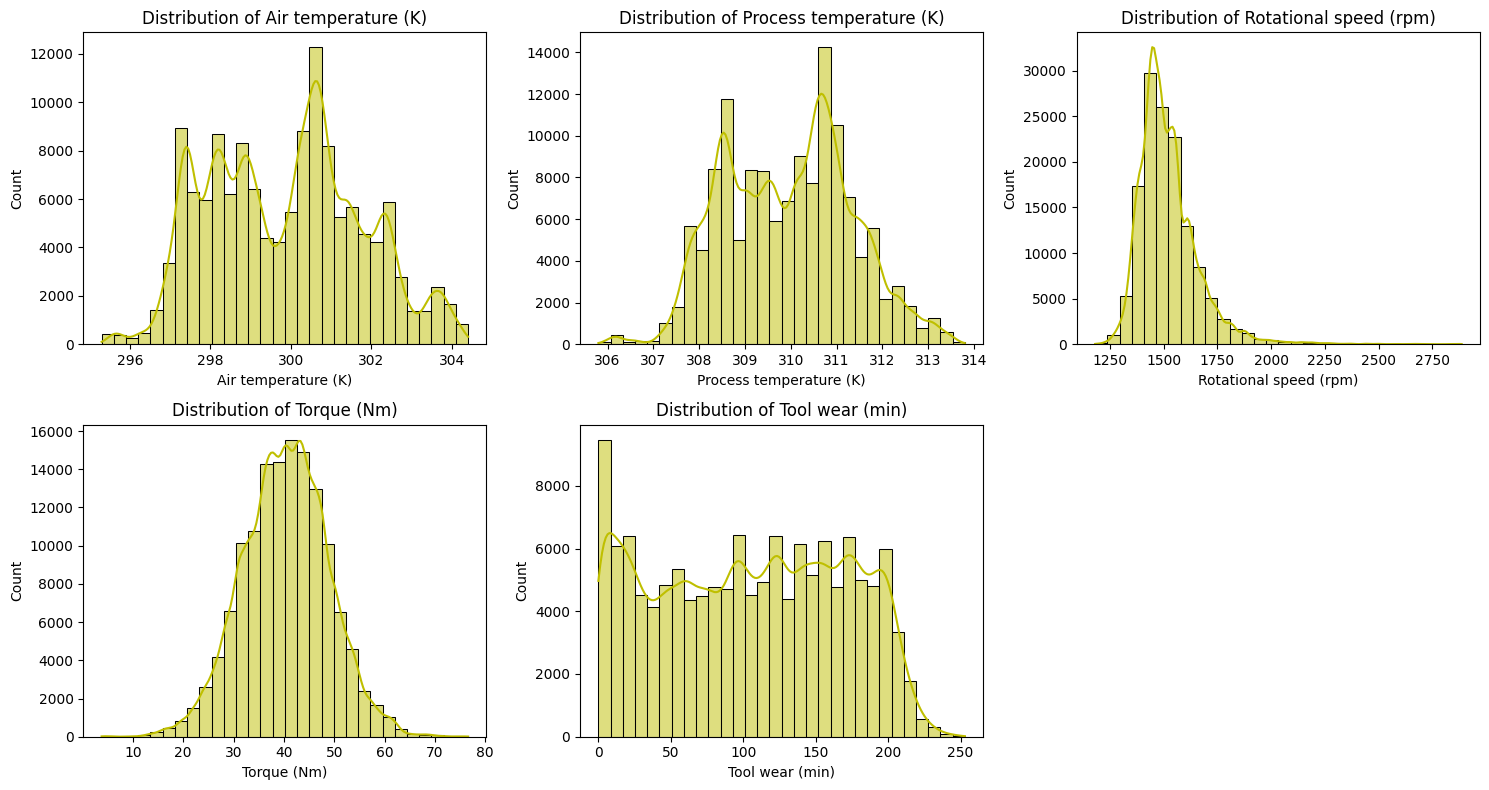

In [63]:
# 1. Feature Distribution Visualization
features = ['Air temperature (K)', 'Process temperature (K)','Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)']

plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color='y')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

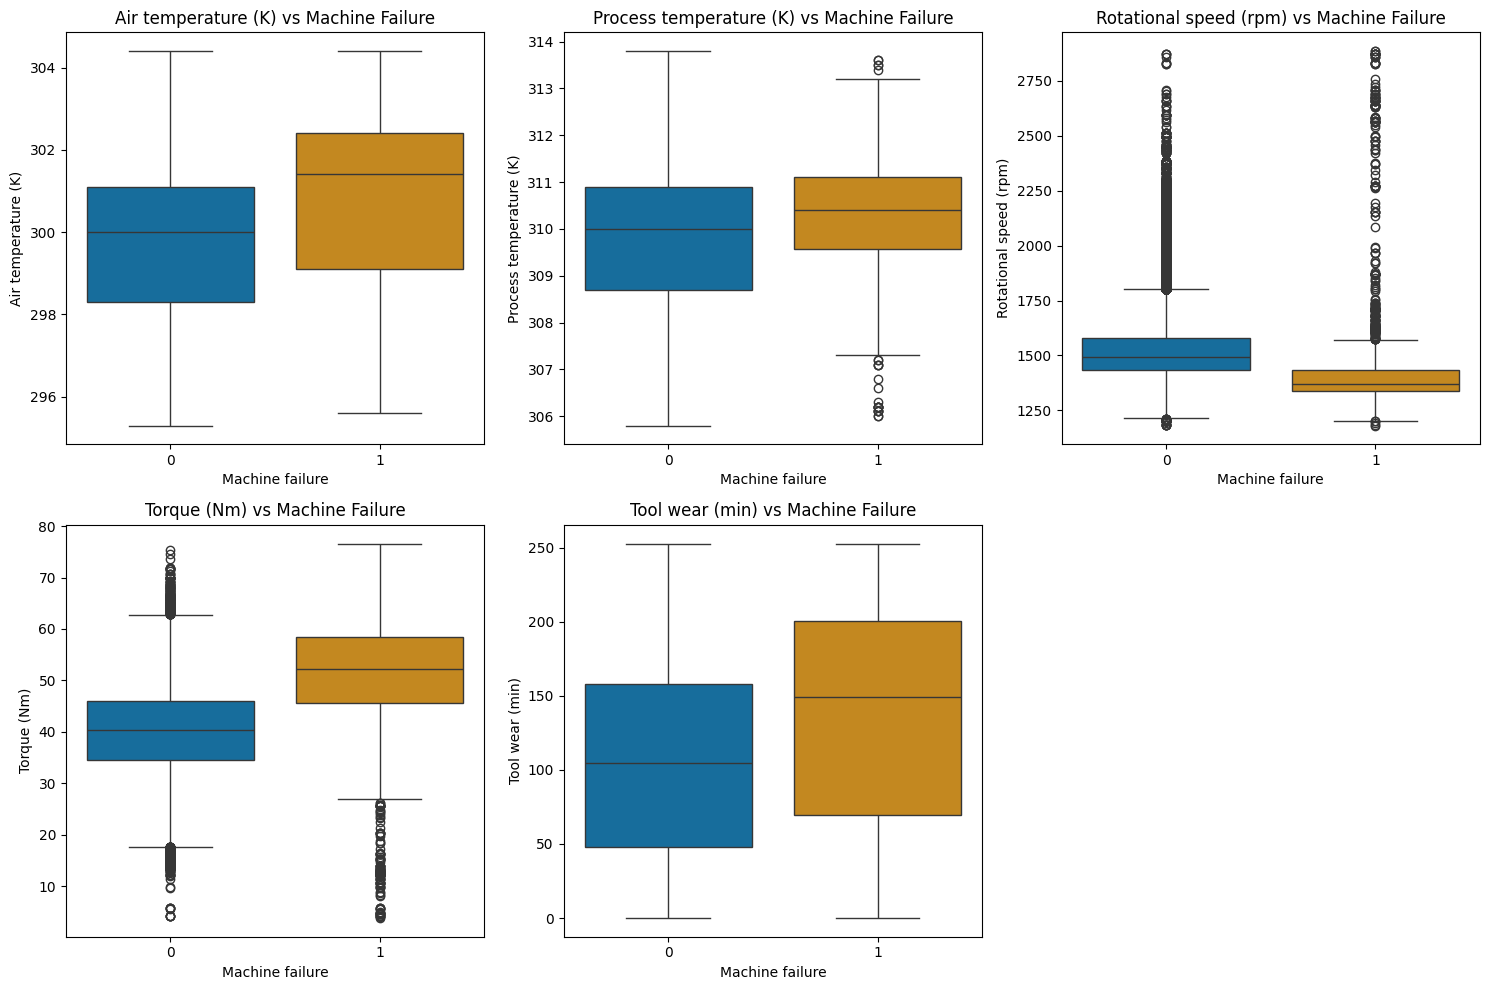

In [64]:
# 2. Failed vs Non-Failed Machines
plt.figure(figsize=(15,10))
for i, col in enumerate(features, 1):
    plt.subplot(2,3,i)
    sns.boxplot(x='Machine failure', y=col, data=df, palette='colorblind')
    plt.title(f'{col} vs Machine Failure')
plt.tight_layout()
plt.show()

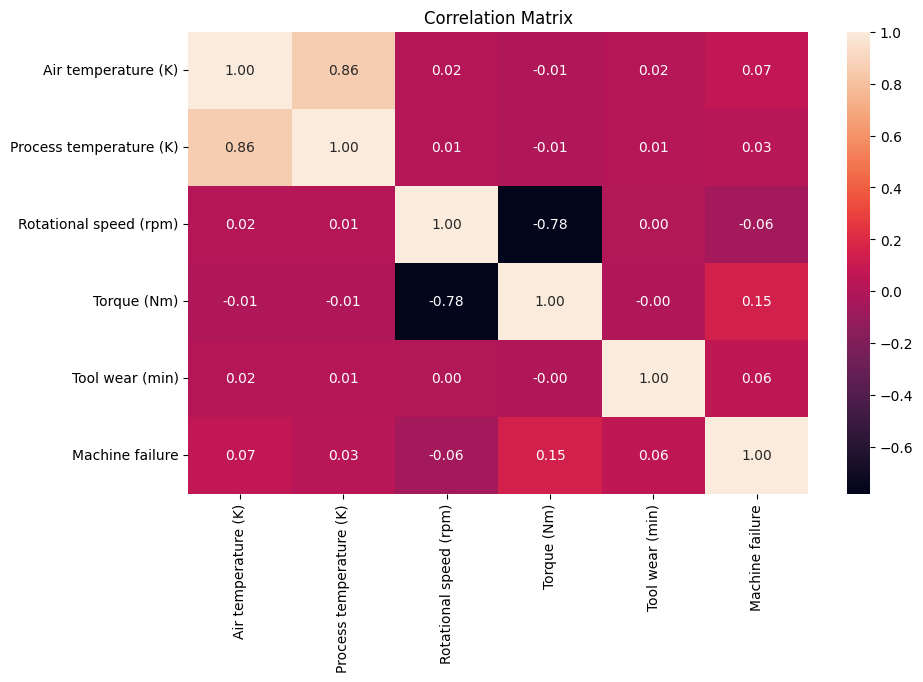

In [65]:
# 3. Correlation analysis
plt.figure(figsize=(10, 6))
corr = df[features + ['Machine failure']].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix") 
plt.show()

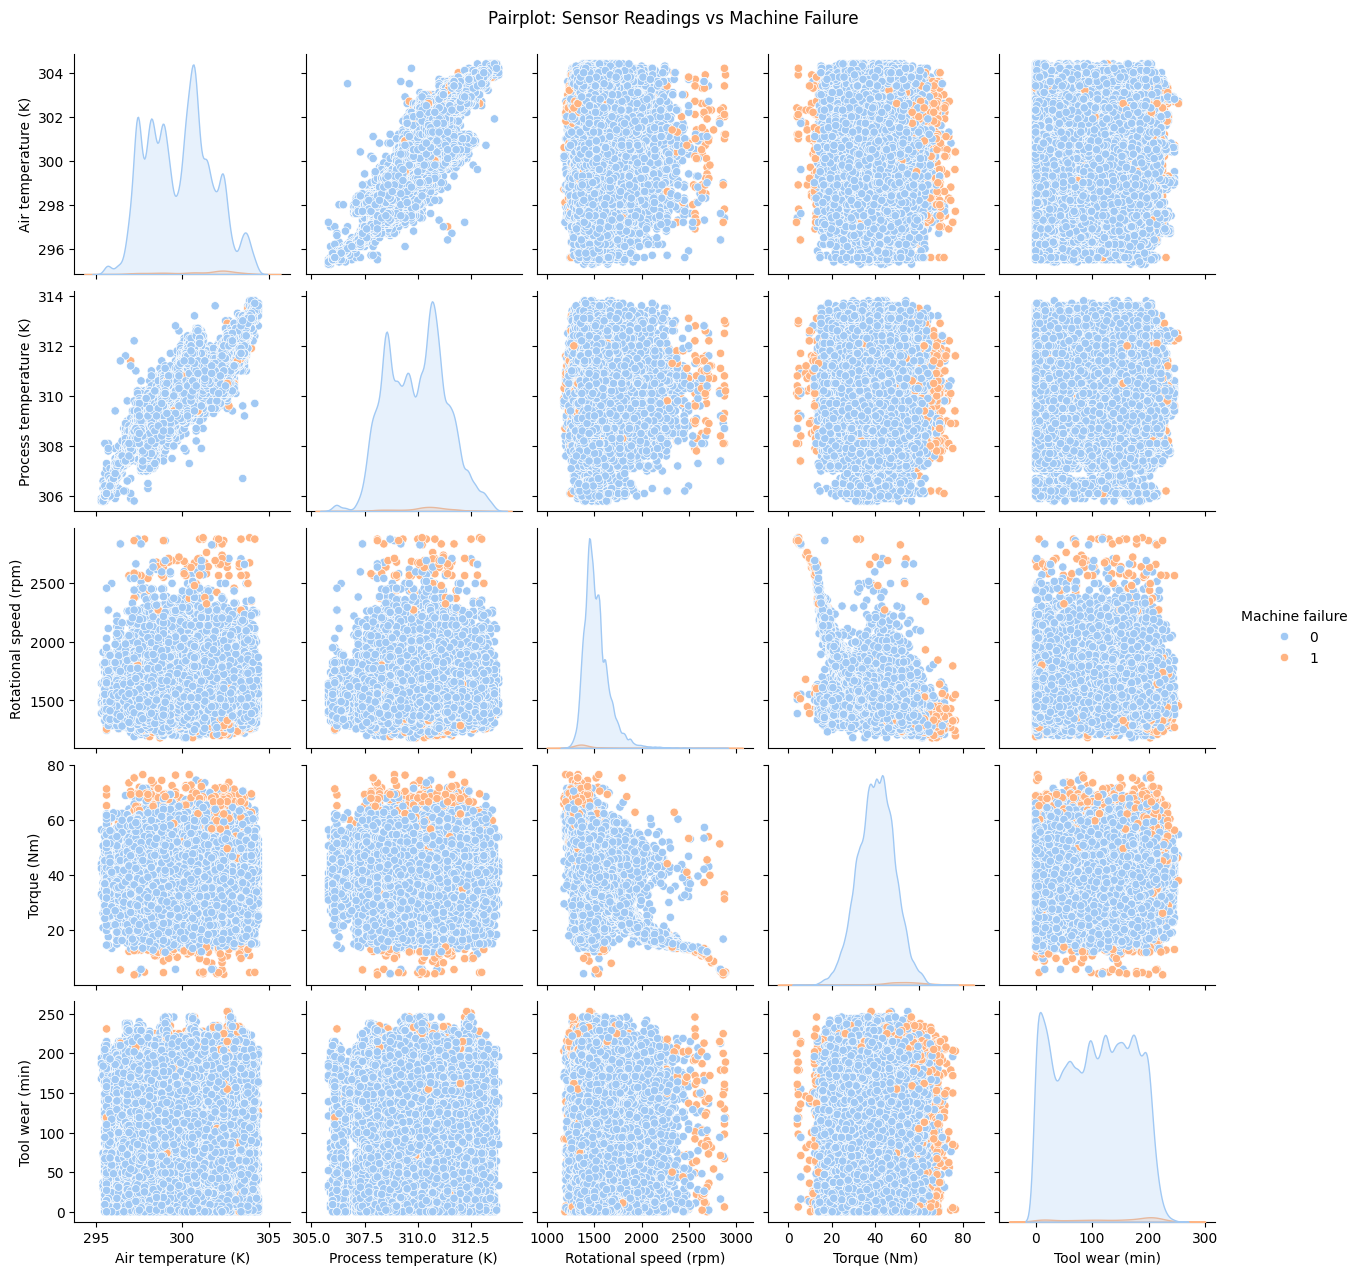

In [66]:
# 4. Pairplot (Feature Relationship Overview)
sns.pairplot(df[features + ['Machine failure']], hue='Machine failure', diag_kind='kde', palette='pastel')
plt.suptitle("Pairplot: Sensor Readings vs Machine Failure", y=1.02)
plt.show()

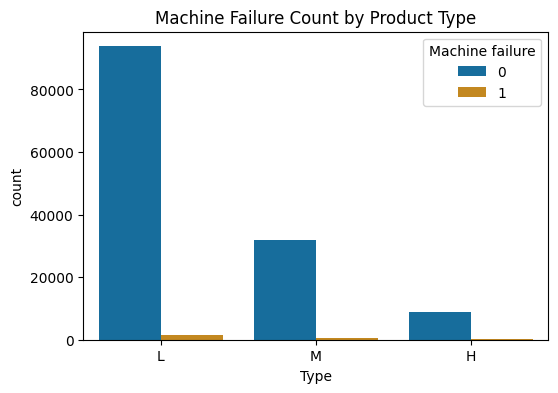

In [67]:
# 5. Countplot for machine failure count by product type
plt.figure(figsize=(6,4))
sns.countplot(x='Type', hue='Machine failure', data=df, palette='colorblind')
plt.title('Machine Failure Count by Product Type')
plt.show()

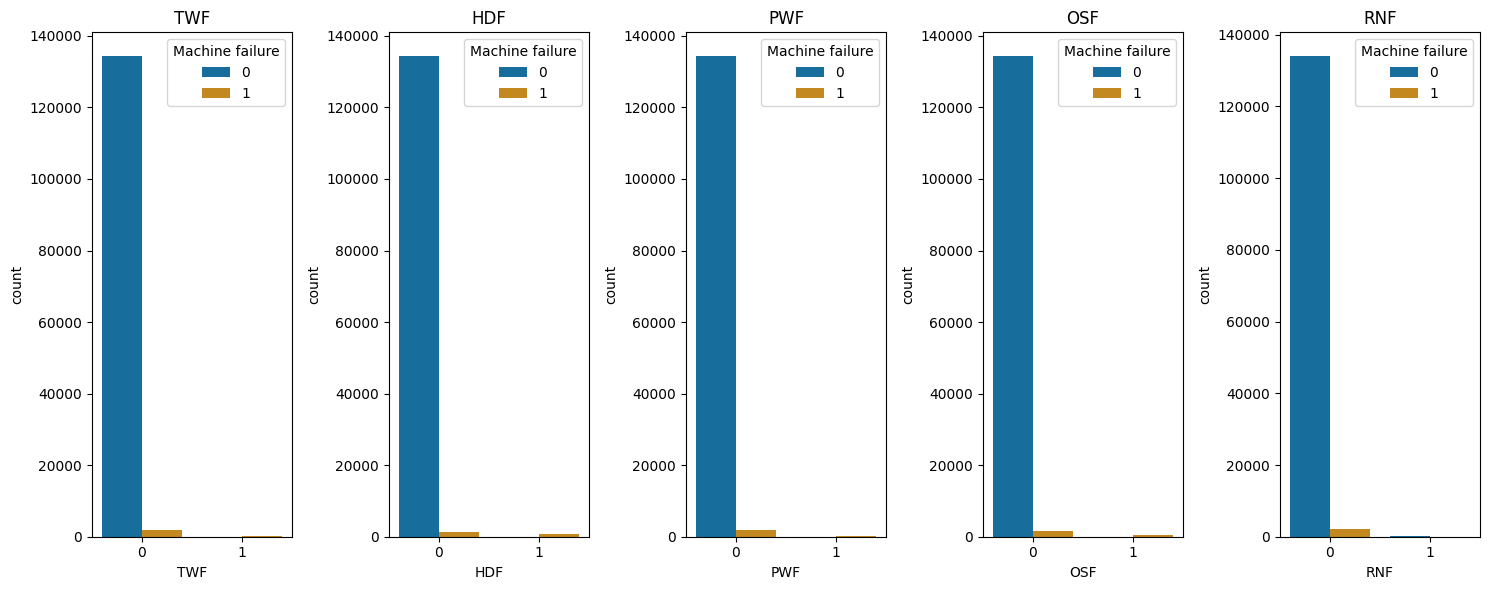

In [68]:
# 6. Countplots for each operational feature against Machine failure
operational_features = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

plt.figure(figsize=(15,6))
for i, col in enumerate(operational_features):
    plt.subplot(1, len(operational_features), i+1)
    sns.countplot(x=col, hue='Machine failure', data=df, palette='colorblind')
    plt.title(col)
plt.tight_layout()
plt.show()

### Step-6. Separating features (X) and target variable (Y)

In [69]:
X = df.drop(columns=['id','Machine failure'])
Y = df[['Machine failure']]
print(X.head())
print('-------')
print(Y.head())

   Product ID Type  Air temperature (K)  Process temperature (K)  \
0       50096    L                300.6                    309.6   
1       20343    M                302.6                    312.1   
2       49454    L                299.3                    308.5   
3       53355    L                301.0                    310.9   
4       24050    M                298.0                    309.0   

   Rotational speed (rpm)  Torque (Nm)  Tool wear (min)  TWF  HDF  PWF  OSF  \
0                    1596         36.1              140    0    0    0    0   
1                    1759         29.1              200    0    0    0    0   
2                    1805         26.5               25    0    0    0    0   
3                    1524         44.3              197    0    0    0    0   
4                    1641         35.4               34    0    0    0    0   

   RNF  Temp_diff  
0    0        9.0  
1    0        9.5  
2    0        9.2  
3    0        9.9  
4    0       11.

### Step-7. Preprocessing Using Pipelines

**A preprocessing pipeline is created to ensure all features are cleaned and transformed consistently before model training.**

**Steps Involved:**    
    **Numeric Features:** Missing values are imputed using the median, followed by scaling with StandardScaler.    
    **Categorical Features:** Missing values are imputed with the most frequent category, then encoded using one-hot encoding.   
    **ColumnTransformer:** Combines numeric and categorical pipelines into a unified preprocessing workflow.


In [70]:
# Separating numeric and categorical columns
categorical_col = list(X.columns[X.dtypes=='object'])
numeric_col = list(X.columns[X.dtypes!='object'])

# Creating categorical pipeline that handles missing data and scales text data
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore',sparse_output=False))

# Creating numerical pipeline that handles missing data and also scales numerical data
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler())

# combining both the pipelines
preprocessor = ColumnTransformer([
        ('cat',cat_pipe,categorical_col ),
        ('con',num_pipe,numeric_col)
    ]).set_output(transform='pandas')

print("Preprocessing pipeline created successfully.")
preprocessor

Preprocessing pipeline created successfully.


,transformers,"[('cat', ...), ('con', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [71]:
# using the preprocessor to fit and transform X data
X_preprocessor = preprocessor.fit_transform(X)
X_preprocessor.head()


,cat__Type_H,cat__Type_L,cat__Type_M,con__Product ID,con__Air temperature (K),con__Process temperature (K),con__Rotational speed (rpm),con__Torque (Nm),con__Tool wear (min),con__TWF,con__HDF,con__PWF,con__OSF,con__RNF,con__Temp_diff
0,0.0,1.0,0.0,0.453780,0.395880,-0.246230,0.545416,-0.499711,0.556417,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,-1.094793
1,0.0,0.0,1.0,-1.653456,1.469856,1.558605,1.720308,-1.323028,1.494433,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,-0.587143
2,0.0,1.0,0.0,0.408311,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,-0.891733
3,0.0,1.0,0.0,0.684597,0.610675,0.692284,0.026445,0.464745,1.447532,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,-0.181023
4,0.0,0.0,1.0,-1.390910,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.935808


In [72]:
# Cleaning column names
new_cols = []
for i in X_preprocessor.columns:
    c = i.split('__')[-1]
    new_cols.append(c)
print(new_cols)

# Assigning cleaned column names to X_preprocessor
X_preprocessor.columns = new_cols
X_preprocessor.head()

['Type_H', 'Type_L', 'Type_M', 'Product ID', 'Air temperature (K)', 'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Temp_diff']


,Type_H,Type_L,Type_M,Product ID,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),TWF,HDF,PWF,OSF,RNF,Temp_diff
0,0.0,1.0,0.0,0.453780,0.395880,-0.246230,0.545416,-0.499711,0.556417,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,-1.094793
1,0.0,0.0,1.0,-1.653456,1.469856,1.558605,1.720308,-1.323028,1.494433,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,-0.587143
2,0.0,1.0,0.0,0.408311,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,-0.891733
3,0.0,1.0,0.0,0.684597,0.610675,0.692284,0.026445,0.464745,1.447532,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,-0.181023
4,0.0,0.0,1.0,-1.390910,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.935808


### Step-8. Splitting Data into Train and Test

**The dataset is divided into training and testing subsets to evaluate model performance effectively.**   
    Training Set (80%) → used to train the model  
    Testing Set (20%) → used to evaluate model performance

In [73]:
xtrain,xtest,ytrain,ytest = train_test_split(X_preprocessor,Y,train_size=0.75,random_state=21)
print(f'xtrain.shape: {xtrain.shape}')
print(f'xtest.shape: {xtest.shape}')
print(f'ytrain.shape: {ytrain.shape}')
print(f'ytest.shape: {ytest.shape}')

xtrain.shape: (102321, 15)
xtest.shape: (34108, 15)
ytrain.shape: (102321, 1)
ytest.shape: (34108, 1)


In [74]:
ytrain.value_counts()

Machine failure
0                  100713
1                    1608
Name: count, dtype: int64

**Since failure cases were very few, balancing the data using class_weight this works directly with training models but does not allow a fair comparison across all models. Therefore, for selecting the best model, I applied SMOTE to generate synthetic samples and balance the classes. After identifying the best model, class_weight will be use to further improve its performance.**

In [75]:
# Handling class imbalance (SMOTE)
from imblearn.over_sampling import SMOTE

In [76]:
# Applying SMOTE
smote = SMOTE()
x_train_smote,y_train_smote = smote.fit_resample(xtrain,ytrain)

# Checking balanced counts
y_train_smote.value_counts()

Machine failure
0                  100713
1                  100713
Name: count, dtype: int64

### Step-9. Choosing the best Model/Algorithm Evaluation

In [77]:
# Testing different ML models
models = [
    LogisticRegression(),      # Logistic Regression model
    DecisionTreeClassifier(),  # Decision Tree model
    RandomForestClassifier(),  # Random Forest ensemble model
    GaussianNB(),              # Gaussian Naive Bayes model
    XGBClassifier()            # XGBoost classifier
]

In [78]:
# Function to train the model and calculate all performance metrics
def evaluate_model_performance(model, x_train_smote, y_train_smote, xtest, ytest):

    # Train model
    model.fit(x_train_smote, y_train_smote)

    # Predictions
    ypred_train_smote = model.predict(x_train_smote)
    ypred_test = model.predict(xtest)

    # Probabilities for ROC-AUC
    ysampl_proba = model.predict_proba(x_train_smote)[:, 1]
    ytest_proba = model.predict_proba(xtest)[:, 1]

    # F1, Accuracy & ROC-AUC scores
    f1_train_smote = f1_score(y_train_smote, ypred_train_smote)
    f1_test = f1_score(ytest, ypred_test)
    accuracy_train_smote = accuracy_score(y_train_smote,ypred_train_smote)
    accuracy_test = accuracy_score(ytest,ypred_test)
    roc_auc_train_smote = roc_auc_score(y_train_smote, ysampl_proba)
    roc_auc_test = roc_auc_score(ytest, ytest_proba)

    # Cross-validation score
    cv_score = cross_val_score(model, x_train_smote, y_train_smote, cv=4, scoring='f1_macro').mean()

    # Return results
    return {
        'Model': type(model).__name__,
        'F1_train_smote': f1_train_smote,
        'F1_Test': f1_test,
        'F1_CV': cv_score,
        'Accuracy_train_smote' : accuracy_train_smote,
        'Accuracy_Test' : accuracy_test,
        'ROC_AUC_train_smote': roc_auc_train_smote,
        'ROC_AUC_Test': roc_auc_test
    }

In [79]:
# Function to evaluate all models and collect their scores
def evaluate_model(models, x_train_smote, y_train_smote, xtest, ytest):
    res = []
    for m in models:

        # Get performance metrics for each model
        r = evaluate_model_performance(m, x_train_smote, y_train_smote, xtest, ytest)

        # Store the results in a list
        res.append(r)

    # Convert list of results into a DataFrame
    results_df = pd.DataFrame(res)
    return results_df

# Run evaluation for all models
score_results_df = evaluate_model(models, x_train_smote, y_train_smote, xtest, ytest)

In [80]:
# Compairing all score
score_results_df

,Model,F1_train_smote,F1_Test,F1_CV,Accuracy_train_smote,Accuracy_Test,ROC_AUC_train_smote,ROC_AUC_Test
0,LogisticRegression,0.884314,0.526379,0.893503,0.894284,0.976838,0.940833,0.935312
1,DecisionTreeClassifier,0.999935,0.549806,0.982465,0.999935,0.979594,1.000000,0.884852
2,RandomForestClassifier,0.999935,0.789523,0.994474,0.999935,0.993403,0.999998,0.954935
3,GaussianNB,0.871978,0.852046,0.884916,0.886479,0.995866,0.942961,0.936765
4,XGBClassifier,0.990921,0.759425,0.987945,0.990974,0.992143,0.999521,0.954024


**After comparing all model performance metrics such as F1 Score, ROC_AUC, and cross-validation results, the RandomForestClassifier stands out as the most reliable model for predicting machine failures.**

Although Gaussian Naive Bayes achieved the highest F1 score on the test set, its lower performance on the training and cross-validation results shows that it is not stable or consistent.

Similarly, XGBClassifier achieved the highest ROC_AUC score, indicating good class separation, but its low F1 Score means it is missing many actual machine failure cases, which is not acceptable for predictive maintenance.

Overall, RandomForestClassifier provides the best overall balance across all metrics. It performs strongly on the training, testing, and cross-validation sets without overfitting. 

### Step-10. Model building

**10.1. Final Model Building**

After selecting RandomForestClassifier as the best-performing model, I did not use SMOTE again for final model training.

Instead, for the final model, I trained Random Forest on the original imbalanced dataset and applied: **class_weight = 'balanced'**

This approach helps the model pay more attention to the minority class (machine failures) and improves precision, recall, and F1-score, without creating synthetic samples.

In [81]:
# Final model building
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_leaf=2,
    min_samples_split=4,
    class_weight='balanced',
)

rf_balanced.fit(xtrain, ytrain)
print('Final model build')

# Score Checking for x_train_smote,y_train_smote and xtest,ytest
print('Accuracy score for (xtrain, ytrain) is:',round(rf_balanced.score(xtrain, ytrain), 2))
print('Accuracy score for (xtest, ytest) is:',round(rf_balanced.score(xtest, ytest), 2))

Final model build
Accuracy score for (xtrain, ytrain) is: 0.99
Accuracy score for (xtest, ytest) is: 0.99


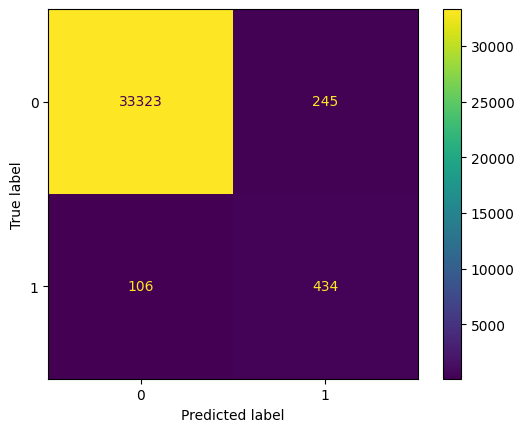

In [82]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_balanced,xtest,ytest)

In [83]:
# Classification report
print(classification_report(ytest,rf_balanced.predict(xtest)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     33568
           1       0.64      0.80      0.71       540

    accuracy                           0.99     34108
   macro avg       0.82      0.90      0.85     34108
weighted avg       0.99      0.99      0.99     34108



After building the initial RandomForest model, the precision and F1-score for the minority class were still low, even though the overall accuracy was high.          
To improve the model’s ability to correctly detect machine failures, hyperparameter tuning is performed.     
    
**Hyperparameter tuning helps find the best settings for the model so it can learn better patterns, reduce errors, and give higher precision, recall, and F1-score.**

**10.2. Hyperparameter tunning**

In [84]:
# Performing hyperparameter tuning, i am considering RandomSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [85]:
# Defining parameter grid for tuning RandomForest
params = {
    'max_depth': [6, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 4, 6, 8, 10],
    'class_weight': ['balanced']
}

# Base RandomForest model
base_model = RandomForestClassifier()

# RandomizedSearchCV for hyperparameter tuning
rscv = RandomizedSearchCV(estimator=base_model,param_distributions=params,cv=3,scoring='f1_macro')

# Fit tuning on imbalanced train data
rscv.fit(xtrain, ytrain)

,estimator,RandomForestClassifier()
,param_distributions,"{'class_weight': ['balanced'], 'max_depth': [6, 8, ...], 'min_samples_split': [2, 4, ...]}"
,n_iter,10
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [86]:
# Best parameters from tuning
rscv.best_params_

{'min_samples_split': 4, 'max_depth': 20, 'class_weight': 'balanced'}

In [87]:
# Final RandomForest model with best parameters
best_rfc = rscv.best_estimator_

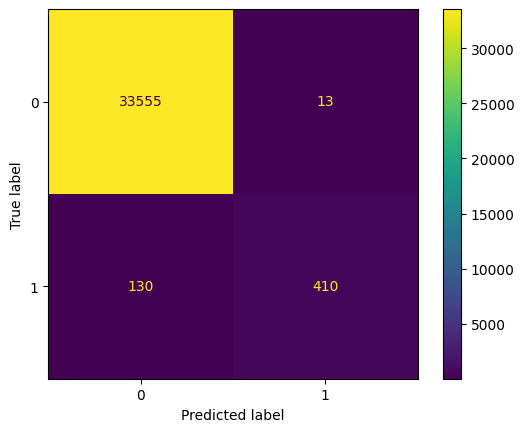

In [88]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rfc,xtest,ytest)

In [89]:
# Classification report
print(classification_report(ytest,best_rfc.predict(xtest)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33568
           1       0.97      0.76      0.85       540

    accuracy                           1.00     34108
   macro avg       0.98      0.88      0.92     34108
weighted avg       1.00      1.00      1.00     34108



**Observations:** Before tuning, the model achieved high overall accuracy (0.99) but struggled to correctly predict rare machine failures (class 1), with precision 0.64 and F1-score 0.71. After hyperparameter tuning, the model’s performance on failures improved significantly — precision increased to 0.97, F1-score to 0.85, while maintaining excellent accuracy on non-failure cases. This shows that tuning not only enhances the model’s ability to detect rare events but also balances precision and recall, making it more reliable for predictive maintenance.

**10.3. ROC-AUC Curve for Best Model**

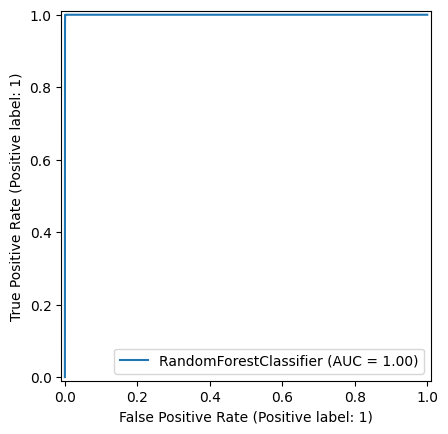

In [90]:
# Ploattinf ROC-AUC curve for train data.
RocCurveDisplay.from_estimator(best_rfc,xtrain,ytrain)

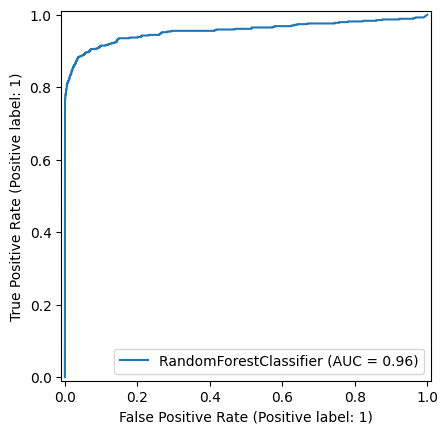

In [91]:
# Ploattinf ROC-AUC curve for test data.
RocCurveDisplay.from_estimator(best_rfc,xtest,ytest)

### Step-11. Feature Importance

                    Feature  Importance
7               Torque (Nm)    0.191264
6    Rotational speed (rpm)    0.181863
8           Tool wear (min)    0.097256
12                      OSF    0.093237
10                      HDF    0.092673
9                       TWF    0.072467
11                      PWF    0.067645
14                Temp_diff    0.060747
4       Air temperature (K)    0.053233
3                Product ID    0.049025
5   Process temperature (K)    0.032942
1                    Type_L    0.002937
0                    Type_H    0.002344
2                    Type_M    0.002214
13                      RNF    0.000153


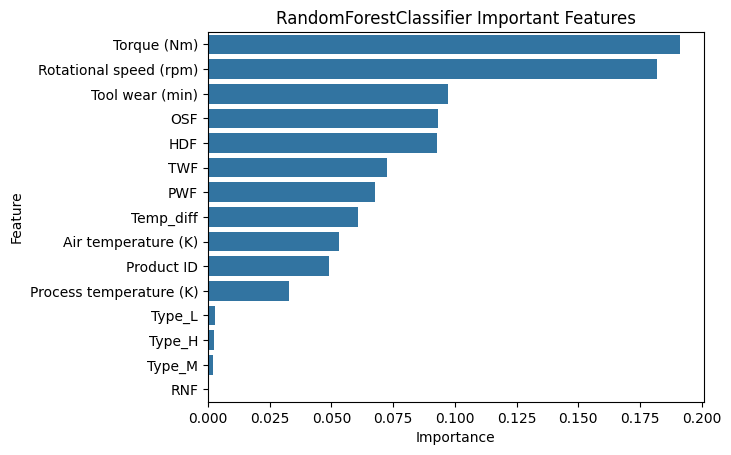

In [92]:
# Checking best feature for prediction
importance_df = pd.DataFrame({
    'Feature': xtest.columns,
    'Importance': best_rfc.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Ploating RandomForestClassifier Feature Importance
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('RandomForestClassifier Important Features')
plt.show()

**Feature Importance Analysis RandomForestClassifier**     
**1.Most Important Features:** Torque (Nm), Rotational speed (rpm), OSF, HDF, TWF, PWF (engineered failure indicators)
It means the machine’s load, speed, and failure-related engineered features play the biggest role in predicting whether a machine will fail or not.     
**2.Medium-Level Features:** Tool wear (min), Temp_diff, Air temperature (K)  
These give useful extra information about machine condition and environment.    
**3.Less Important Features:** Product ID, Process temperature (K)
Their impact on predicting failure is quite small.     
**4.Almost No Impact Features:** Type_H, Type_L, Type_M, RNF   
The machine Type category doesn’t influence failures much, and RNF behaves as expected with almost zero importance.

The RandomForest model primarily depends on mechanical load indicators (Torque, RPM) and engineered failure flags (OSF, HDF, TWF, PWF).
Core sensor readings like Tool wear and Temperatures still help but are less influential.    
This confirms that the combination of operational sensor data + engineered features is driving the model’s predictive strength.

### Step-12. Results and Insights (Final Model: RandomForest)

**12.1 Model Performance**
The final RandomForest model achieved 100% accuracy and performed strongly on the majority class.    
For machine failures (minority class), the model reached:   
    Precision: 0.97   
    Recall: 0.76   
    F1-score: 0.85

**12.2 Key Insights**
Key factors influencing failure include Rotational Speed, Torque, engineered failure indicators (OSF, HDF, TWF, PWF), and Temperature Difference.

**12.3 Conclusion**
Overall, the model provides stable, reliable, and practical performance, helping industries reduce downtime, improve safety, and plan maintenance more efficiently.

### Step-13. Using this best RandomForestClassifier model for out of sample predictions

In [93]:
# Laoding out of sample test data
path2 = r'https://raw.githubusercontent.com/akash-ostwal/ML-Project-Machine-Failure-Prediction/refs/heads/main/Data%20sets/datasets-test.csv'
xnew = pd.read_csv(path2)
xnew.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [94]:
# Renaming columns for better readability → for replacing [ ] with ( )
xnew.columns = ['id', 'Product ID', 'Type', 'Air temperature (K)', 'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [95]:
# Droping unessery column
xnew = xnew.drop(columns=['id'])

In [96]:
# Cleaning Product ID column → for removing letters and converting to int
xnew['Product ID'] = xnew['Product ID'].str.replace('[LMH]', '', regex=True).astype(int)

In [97]:
# Creating a new feature (Which is the difference between Process temperature (K) and Air temperature (K).)
xnew['Temp_diff'] = xnew['Process temperature (K)'] - xnew['Air temperature (K)']

In [98]:
# using the preprocessor to fit and transform xnew data
xnew_preprocessor = preprocessor.fit_transform(xnew)
xnew_preprocessor.head()

,cat__Type_H,cat__Type_L,cat__Type_M,con__Product ID,con__Air temperature (K),con__Process temperature (K),con__Rotational speed (rpm),con__Torque (Nm),con__Tool wear (min),con__TWF,con__HDF,con__PWF,con__OSF,con__RNF,con__Temp_diff
0,0.0,1.0,0.0,0.513106,1.313830,1.126570,-0.153806,-0.274579,-0.693494,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-0.896035
1,0.0,1.0,0.0,0.723077,0.990824,0.765635,1.375097,-1.356341,-1.366729,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-0.794200
2,0.0,1.0,0.0,0.484968,0.775487,0.332512,0.031949,-0.309854,-0.129855,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-0.997871
3,0.0,0.0,1.0,-1.584057,0.129475,-0.244985,-0.296694,0.854217,-1.554608,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-0.590528
4,0.0,0.0,1.0,-1.688759,1.906008,1.704068,-0.039496,0.113445,0.151964,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-1.201543


In [99]:
# Cleaning column names
new_cols = []
for i in xnew_preprocessor.columns:
    c = i.split('__')[-1]
    new_cols.append(c)
print(new_cols)

# Assigning cleaned column names to xnew_preprocessor
xnew_preprocessor.columns = new_cols
xnew_preprocessor.head()

['Type_H', 'Type_L', 'Type_M', 'Product ID', 'Air temperature (K)', 'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Temp_diff']


,Type_H,Type_L,Type_M,Product ID,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),TWF,HDF,PWF,OSF,RNF,Temp_diff
0,0.0,1.0,0.0,0.513106,1.313830,1.126570,-0.153806,-0.274579,-0.693494,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-0.896035
1,0.0,1.0,0.0,0.723077,0.990824,0.765635,1.375097,-1.356341,-1.366729,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-0.794200
2,0.0,1.0,0.0,0.484968,0.775487,0.332512,0.031949,-0.309854,-0.129855,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-0.997871
3,0.0,0.0,1.0,-1.584057,0.129475,-0.244985,-0.296694,0.854217,-1.554608,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-0.590528
4,0.0,0.0,1.0,-1.688759,1.906008,1.704068,-0.039496,0.113445,0.151964,-0.038412,-0.073294,-0.048563,-0.062331,-0.048106,-1.201543


In [100]:
# Predicting machine failure on out of sample data
machine_failure_predicted = best_rfc.predict(xnew_preprocessor)
machine_failure_predicted[:5]

array([0, 0, 0, 0, 0])

In [101]:
# Adding predictions to the new dataset
xnew['Machine Failure Predicted'] = machine_failure_predicted
xnew.head()

,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),TWF,HDF,PWF,OSF,RNF,Temp_diff,Machine Failure Predicted
0,50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0,9.2,0
1,53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0,9.3,0
2,50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0,9.1,0
3,21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0,9.5,0
4,19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0,8.9,0


In [102]:
# Exporting predictions to CSV file
import os
xnew.to_csv('Outputs/Predicted Machine Failure Results.csv',index=False)

**Final Remarks:** The project from data cleaning to model building, tuning, evaluation, and out-of-sample prediction has been successfully completed. The final model has been used to generate predictions for new unseen data, and the results have been exported for practical use. This completes the end-to-end Machine Failure Prediction pipeline.